<a href="https://colab.research.google.com/github/thomascong121/SocialDistance/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [219]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%%capture
!pip install gluoncv
!pip install mxnet-cu101

In [0]:
import gluoncv
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict

from mxnet import nd
import mxnet as mx
from skimage import io

import cv2
import os

In [222]:
!ls '/content/drive/My Drive/social distance/0.png'

'/content/drive/My Drive/social distance/0.png'


In [223]:
!nvidia-smi

Sun Apr 26 10:09:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    34W / 250W |   5679MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [224]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [0]:
img_path = '/content/drive/My Drive/social distance/0.png'
img = io.imread(img_path)

In [0]:
video_path = '/content/drive/My Drive/social distance/TownCentreXVID.avi'

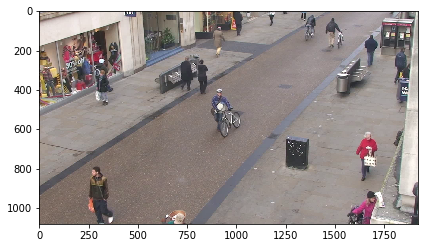

In [227]:
io.imshow(img)
io.show()

In [0]:
'''
step0 install gluoncv
pip install --upgrade mxnet gluoncv
'''
class Model_Zoo:
    def __init__(self,selected_model, device):
        self.device = device
        self.net = model_zoo.get_model(selected_model, pretrained=True, ctx = self.device)

    def __call__(self,image,display=False):
        '''get bbox for input image'''
        image = nd.array(image)
        x, orig_img = data.transforms.presets.yolo.transform_test(image)
        self.reshape = image.shape[0]/orig_img.shape[0]
        self.benchmark = max(orig_img.shape[:2])
        x = x.copyto(self.device)
        box_ids, scores, bboxes = self.net(x)
        bboxes *= self.reshape
        person_index = []

        #check person class
        for i in range(box_ids.shape[1]):
            if box_ids[0][i][0] == 14 and scores[0][i][0] > 0.7:
                person_index.append(i)
        #select bbox of person
        #p1:bbox id of person
        #p2:confidence score
        #p3:bbox location
        print('======{0} bbox of persons are detected===='.format(len(person_index)))
        p1,p2,p3 = box_ids[0][[person_index],:],scores[0][[person_index],:],bboxes[0][[person_index],:]
        '''这里改了一下'''
        #calaulate bbox coordinate
        bbox_center = self.bbox_center(p3)
        #img with bbox 

        img_with_bbox = utils.viz.cv_plot_bbox(image.astype('uint8'), p3[0], p2[0], p1[0], colors={14: (0,255,0)},class_names = self.net.classes, linewidth=1)
        result_img = self.bbox_distance(bbox_center,img_with_bbox)
        if display:
          plt.imshow(result_img)
          plt.show()
        '''这里改了一下'''
        return result_img, p1, p2, p3, bbox_center

    def show(self, img, p1, p2, p3, bbox_center):
        img = nd.array(img).astype('uint8')
        img_with_bbox = utils.viz.cv_plot_bbox(img, p3[0], p2[0], p1[0], colors={14: (0,255,0)},class_names = self.net.classes, linewidth=1)
        return self.bbox_distance(bbox_center,img_with_bbox)

    def bbox_center(self,bbox_location):
        '''calculate center coordinate for each bbox'''
        rst = []
        for loc in range(bbox_location[0].shape[0]):
            (xmin, ymin, xmax, ymax) = bbox_location[0][loc].copyto(mx.cpu())
            center_x = (xmin+xmax)/2
            center_y = ymax
            rst.append([center_x.asnumpy()[0],center_y.asnumpy()[0]])
        return rst

    def bbox_distance(self,bbox_coord,img,max_detect=160000,safe=40000):
        '''
        calculate distance between each bbox, 
        if distance < max_detect, draw a green line
        if distance < safe, draw a red line
        '''
        def distance(coord0, coord1):
            return (coord0[0] - coord1[0])**2 + (coord0[1] - coord1[1])**2
        #draw the center
        for coor in range(len(bbox_coord)):
            cv2.circle(img,(int(bbox_coord[coor][0]),int(bbox_coord[coor][1])),5,(0, 0, 255),-1)

        for i in range(0, len(bbox_coord)):
            for j in range(i, len(bbox_coord)):
                dist = distance(bbox_coord[i], bbox_coord[j])
                if dist < safe:
                    cv2.line(img,(bbox_coord[i][0],bbox_coord[i][1]),(bbox_coord[j][0],bbox_coord[j][1]),(255,0,0),2)
                elif dist < max_detect:
                    cv2.line(img,(bbox_coord[i][0],bbox_coord[i][1]),(bbox_coord[j][0],bbox_coord[j][1]),(0,255,0),2)
        return img


In [0]:
pretrained_models = 'yolo3_darknet53_voc'
detect_model = Model_Zoo(pretrained_models, mx.gpu())

======12 bbox of persons are detected====


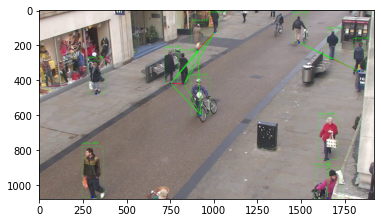

CPU times: user 644 ms, sys: 35.3 ms, total: 679 ms
Wall time: 593 ms


In [230]:
%%time
rst = detect_model(img,display=True)

In [231]:
rst

(array([[[121, 113, 121],
         [120, 112, 120],
         [119, 111, 119],
         ...,
         [219, 222, 212],
         [215, 218, 208],
         [214, 217, 207]],
 
        [[120, 112, 120],
         [121, 113, 121],
         [123, 115, 123],
         ...,
         [218, 221, 211],
         [215, 218, 208],
         [213, 216, 206]],
 
        [[134, 128, 135],
         [136, 130, 137],
         [140, 134, 141],
         ...,
         [216, 219, 209],
         [213, 216, 206],
         [212, 215, 205]],
 
        ...,
 
        [[120, 105,  96],
         [122, 107,  98],
         [123, 108,  99],
         ...,
         [ 51,  65,  58],
         [ 76,  90,  83],
         [ 95, 109, 102]],
 
        [[122, 107,  98],
         [123, 108,  99],
         [125, 110, 101],
         ...,
         [ 51,  65,  58],
         [ 77,  91,  84],
         [ 98, 112, 105]],
 
        [[123, 108,  99],
         [125, 110, 101],
         [127, 112, 103],
         ...,
         [ 51,  65,  58],
  

In [0]:
class Detector:
  def __init__(self, model, save_path = './detections', batch_size = 60, interval = None):
    self.detector = model
    self.save_path = save_path
    self.interval = interval
    self.batch_size = batch_size

  def __call__(self, filename):
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_size = (v_cap.get(cv2.CAP_PROP_FRAME_WIDTH), v_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    fps = v_cap.get(cv2.CAP_PROP_FPS)
    if not os.path.exists(self.save_path):
        os.mkdir(self.save_path)
    print(f'{self.save_path}/{filename.split("/")[-1]}')
    out = cv2.VideoWriter(f'{self.save_path}/{filename.split("/")[-1]}', fourcc, fps,\
                          (int(frame_size[0]), int(frame_size[1])))   
    
    if self.interval is None:
      sample = np.arange(0, v_len)
    else:
      sample = np.arange(0, v_len, self.interval)
    frame = p1 = p2 = p3 = bbox_center =None
    for i in range(v_len):
      success = v_cap.grab()
      
      success, frame = v_cap.retrieve()
      if not success:
        continue
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

      if i in sample:
        frame, p1, p2, p3, bbox_center = self.detector(frame)
      else:
        frame = self.detector.show(frame, p1, p2, p3, bbox_center)
      # plt.imshow(frame)
      # plt.show()
      frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      out.write(frame)

    v_cap.release()
    return out

    


In [0]:
detector = Detector(detect_model, interval = 10)

In [234]:
%%time
detector(video_path)

./detections/TownCentreXVID.avi
======12 bbox of persons are detected====
======13 bbox of persons are detected====
======12 bbox of persons are detected====
======12 bbox of persons are detected====
======12 bbox of persons are detected====
======10 bbox of persons are detected====
======8 bbox of persons are detected====
======9 bbox of persons are detected====
======7 bbox of persons are detected====
======7 bbox of persons are detected====
======7 bbox of persons are detected====
======5 bbox of persons are detected====
======9 bbox of persons are detected====
======9 bbox of persons are detected====
======8 bbox of persons are detected====
======7 bbox of persons are detected====
======8 bbox of persons are detected====
======6 bbox of persons are detected====
======6 bbox of persons are detected====
======8 bbox of persons are detected====
======7 bbox of persons are detected====
======9 bbox of persons are detected====
======9 bbox of persons are detected====
======8 bbox of per

<VideoWriter 0x7fc687aca510>

In [235]:
!ls ./detections

TownCentreXVID.avi
